In [1]:
!pip install tensorflow_federated
!pip install attention

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from attention import Attention
import keras
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import collections
import random
import time
import math
import os

In [3]:
def create_fl_clients(data, target, no_of_clients):
    '''
    data - pandas dataframe
    clients - number of FL clients to split the data
    '''
    datasets = []
    for cid in range(no_of_clients):
        #creating a partition value as per the number of FL clients
        partition_size = math.floor(len(data) / no_of_clients)
        #creating indexes to subset the dataframe
        idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
        #subsetting dataframe
        train_batch = data[idx_from:idx_to]
        target_batch = target[idx_from:idx_to]

        dataset = tf.data.Dataset.from_tensor_slices((train_batch, target_batch)).batch(1)
        datasets.append(dataset)

    return datasets

In [4]:
def model_fn():
    model = create_model_fn()
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(2)
    input_spec = dataset.element_spec
    return tff.learning.models.from_keras_model(
      model,
      input_spec = input_spec,
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [5]:
import time
import datetime

now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

def train(trainer, train_data, val_data, num_rounds, no_of_clients, fit_on):
    train_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR)

    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    #we want to set the federated learning params to be set to default
    state = trainer.initialize()
    #create model for evaluation
    eval = tff.learning.build_federated_evaluation(model_fn)
    return_state = None
    best_loss = None
    #for plotting we declare arrays
    train_acc = []
    train_mse = []
    train_loss = []
    eval_acc = []
    eval_mse = []
    eval_loss = []

    # test_acc = []
    # test_loss = []
    for n in range(num_rounds):
        t1 = time.time()
        print("Training...")
        #passing the new state with randomly chosen training dataset
        result = trainer.next(state, train_data)
        #setting new state for trained parameters
        state = result.state
        #declaring taining metrics
        train_metrics = result.metrics['client_work']['train']
        print("Evaluating...")
        #using learning algorithm we pass the currrent state of round for evaluation
        eval_metrics = eval(trainer.get_model_weights(state), [val_data])
        eval_metrics = eval_metrics['eval']
        print("Done...")
        t2 = time.time()
        print('Round:{a} Train - RMSE:{m:.4f} MAE:{x:.4f}, Loss:{t:.4f} | Eval - RMSE:{b:.4f} MAE:{d:.4f}, Loss:{c:.4f} | Time - {f:.2f}'.format(
              a=n+1,
              m=train_metrics['root_mean_squared_error'],
              x=train_metrics['mean_absolute_error'],
              t=train_metrics['loss'],
              b=eval_metrics['root_mean_squared_error'],
              d=eval_metrics['mean_absolute_error'],
              c=eval_metrics['loss'],
              # d=test_metrics['root_mean_squared_error'],
              # e=test_metrics['loss']
              f=t2-t1
        ))

        #early stopping
        if(best_loss != None and eval_metrics['loss'] >= best_loss):
          print("LOSS DID NOT IMPROVE...")
        else:
          print("Loss improved!")
          return_state = result.state
          best_loss = eval_metrics['loss']
          print("Saving model state...")

        #assigning metrics for plotting purposes
        train_acc.append(train_metrics['root_mean_squared_error'])
        train_mse.append(train_metrics['mean_absolute_error'])
        train_loss.append(train_metrics['loss'])

        eval_acc.append(eval_metrics['root_mean_squared_error'])
        eval_mse.append(eval_metrics['mean_absolute_error'])
        eval_loss.append(eval_metrics['loss'])

        with train_summary_writer.as_default():
          tf.summary.scalar("training/rmse", train_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("training/mse", train_metrics['mean_absolute_error'], step=n+1)

          tf.summary.scalar("validation/rmse", eval_metrics['root_mean_squared_error'], step=n+1)
          tf.summary.scalar("validation/mse", eval_metrics['mean_absolute_error'], step=n+1)

        #using learning algorithm we pass the currrent state of round for testing
        # test_metrics = eval(trainer.get_model_weights(state), [test_client_data])
        # test_metrics = test_metrics['eval']




    return return_state, train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss

In [6]:
import matplotlib
def plot(train_acc, train_mse, train_loss, eval_acc, eval_mse, eval_loss):
  plt.figure(figsize=(16, 6))
  plt.plot(train_acc, label="Training RMSE")
  plt.plot(eval_acc, label="Evaluation RMSE")
  plt.title("RMSE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("RMSE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

  plt.figure(figsize=(16, 6))
  plt.plot(train_mse, label="Training MAE")
  plt.plot(eval_mse, label="Evaluation MAE")
  plt.title("MAE using past " + str(past) + " hours to predict next 1 hour (LR:" + str(SERVER_LR)+ ")")
  plt.xlabel("Rounds")
  plt.ylabel("MAE")
  plt.legend()
  # plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=len(train_acc)))
  plt.show()

In [7]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std
    # scaler = MinMaxScaler(feature_range=(0,1))
    # transformed = scaler.fit_transform(data)
    # return transformed, scaler

In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [9]:
def create_model_fn():
  input = keras.layers.Input(shape=(past, input_size))
  layer = keras.layers.Conv1D(filters=15, kernel_size=2, padding="same", activation="relu")(input)
  layer = tf.keras.layers.MaxPooling1D(pool_size=2)(layer)
  layer = keras.layers.Conv1D(filters=12, kernel_size=2, padding="same", activation="relu")(layer)
  layer = tf.keras.layers.LSTM(32, return_sequences=True)(layer)
  layer = Attention(units=10)(layer)
  output = keras.layers.Dense(future)(layer)

  model = keras.Model(inputs=input, outputs=output)
  return model

In [10]:
s1 = pd.read_csv('../data/final_s1.csv')
#dropping uncessary columns
s1 = s1.drop(['Unnamed: 0'], axis=1)

s2 = pd.read_csv('../data/final_s2.csv')
#dropping uncessary columns
s2 = s2.drop(['Unnamed: 0'], axis=1)

In [11]:
def make_dataset(data, past, split_fraction=0.80):
  train_split = int(split_fraction * int(data.shape[0]))
  step = 1

  features = data[["temp", "wetb", "dewpt", "vappr", "pm10"]]
  features.index = data["datetime"]
  feature_columns = features.columns
  #print(features.head())

  targets = data[["pm2.5"]]
  targets_columns = targets.columns

  features = normalize(features.values, train_split)
  #targets = scaler.transform(targets.values)

  features_df = pd.DataFrame(features, columns = feature_columns)
  #targets = pd.DataFrame(targets, columns = targets_columns)

  input_size = len(features_df.columns)

  x_train, y_train = multivariate_data(features_df.values, targets["pm2.5"].values, 0,
                                                    train_split, past,
                                                    future, step)
  x_val, y_val = multivariate_data(features_df.values, targets["pm2.5"].values,
                                                train_split, None, past,
                                                future, step)
  return x_train, y_train, x_val, y_val

In [12]:
#setting number of clients
NUM_CLIENTS = 2
NUM_FIT = 5
ROUNDS = 100
future = 1
input_size = 5

In [13]:
def optimizers(SERVER_LR, CLIENT_LR):
  server_optimizer_fn=lambda: tf.keras.optimizers.SGD(SERVER_LR, momentum=0.9)
  client_optimizer_fn=lambda: tf.keras.optimizers.SGD(CLIENT_LR, momentum=0.9)

  return server_optimizer_fn, client_optimizer_fn

In [33]:
past = 2
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [34]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-19-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:8.0727 MAE:4.3359, Loss:4.3359 | Eval - RMSE:4.7346 MAE:3.2112, Loss:3.2112 | Time - 57.40
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.9267 MAE:4.0909, Loss:4.0909 | Eval - RMSE:4.4285 MAE:2.8882, Loss:2.8882 | Time - 32.51
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.5002 MAE:3.6454, Loss:3.6454 | Eval - RMSE:4.0365 MAE:2.5798, Loss:2.5798 | Time - 28.85
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.8259 MAE:3.1716, Loss:3.1716 | Eval - RMSE:3.5148 MAE:2.2145, Loss:2.2145 | Time - 32.85
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.1634 MAE:2.8178, Loss:2.8178 | Eval - RMSE:2.8317 MAE:1.6744, Loss:1.6744 | Time - 28.42
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.6502 MAE:2.5517, Loss:2.5517

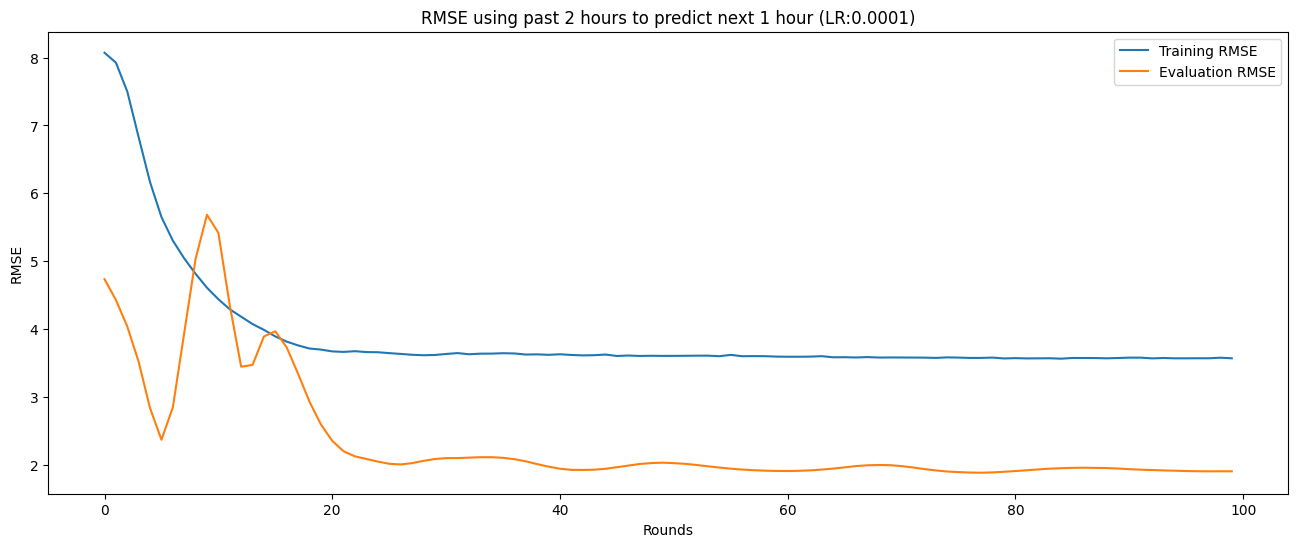

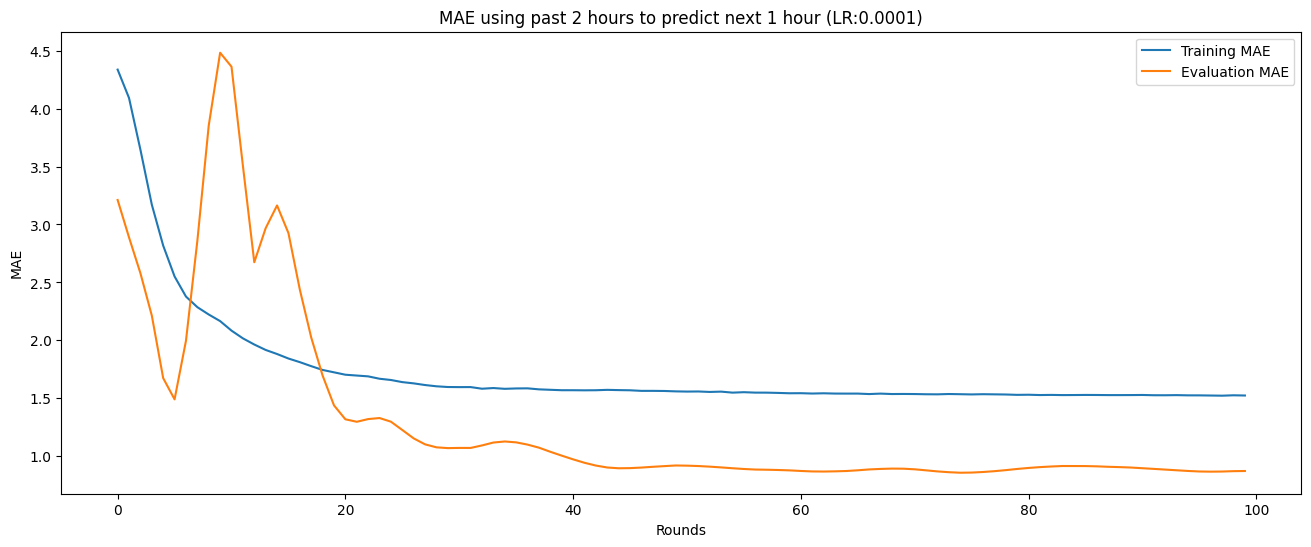

In [35]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [48]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_2h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 26ms/step


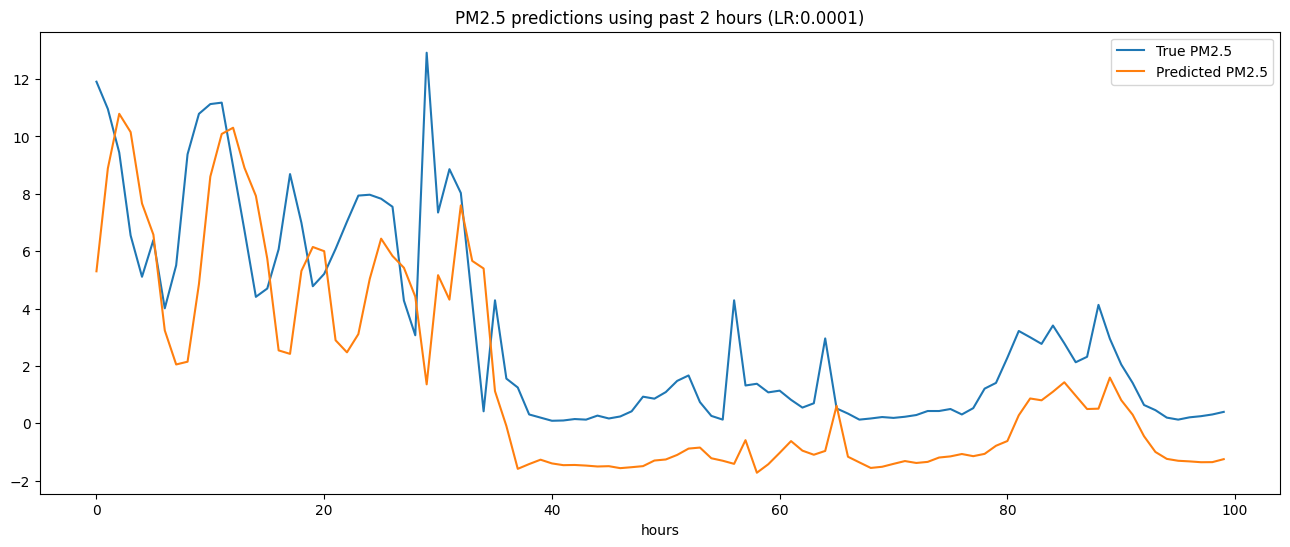

In [49]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [38]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.881305,0.858402


## Past 4

In [50]:
past = 4
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [51]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-19-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.2998 MAE:3.5295, Loss:3.5295 | Eval - RMSE:4.7541 MAE:3.2526, Loss:3.2526 | Time - 64.20
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:6.9709 MAE:3.2993, Loss:3.2993 | Eval - RMSE:4.4834 MAE:2.9847, Loss:2.9847 | Time - 56.13
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.5139 MAE:3.0366, Loss:3.0366 | Eval - RMSE:4.0121 MAE:2.5975, Loss:2.5975 | Time - 60.02
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.0175 MAE:2.7878, Loss:2.7878 | Eval - RMSE:3.2951 MAE:2.0450, Loss:2.0450 | Time - 49.22
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:5.6265 MAE:2.5993, Loss:2.5993 | Eval - RMSE:2.5568 MAE:1.4537, Loss:1.4537 | Time - 46.17
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.3229 MAE:2.4654, Loss:2.4654

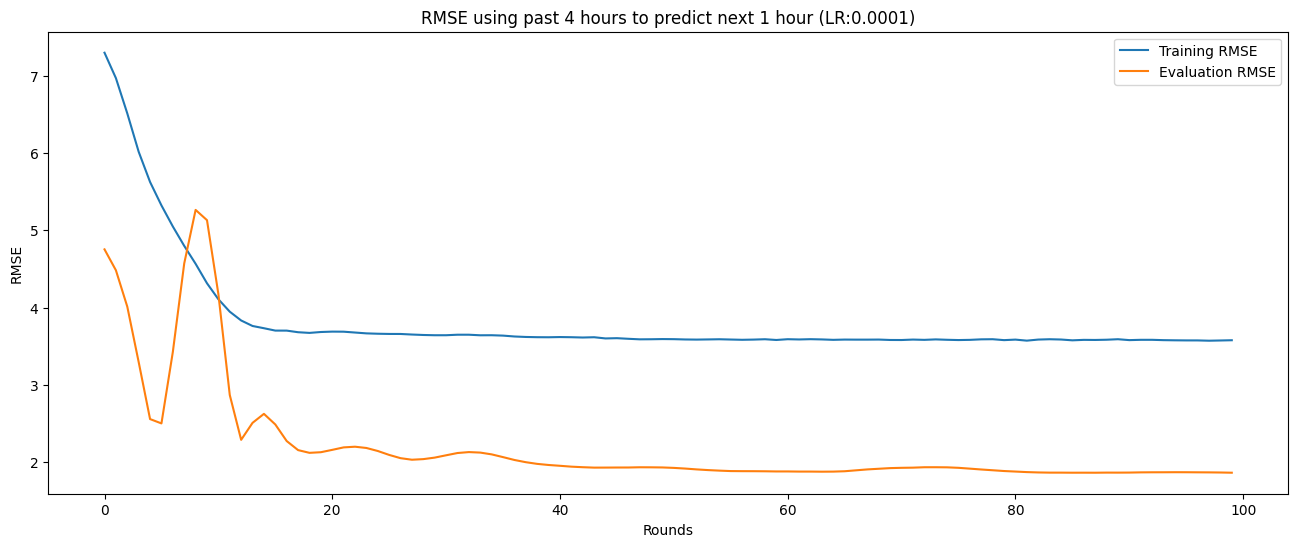

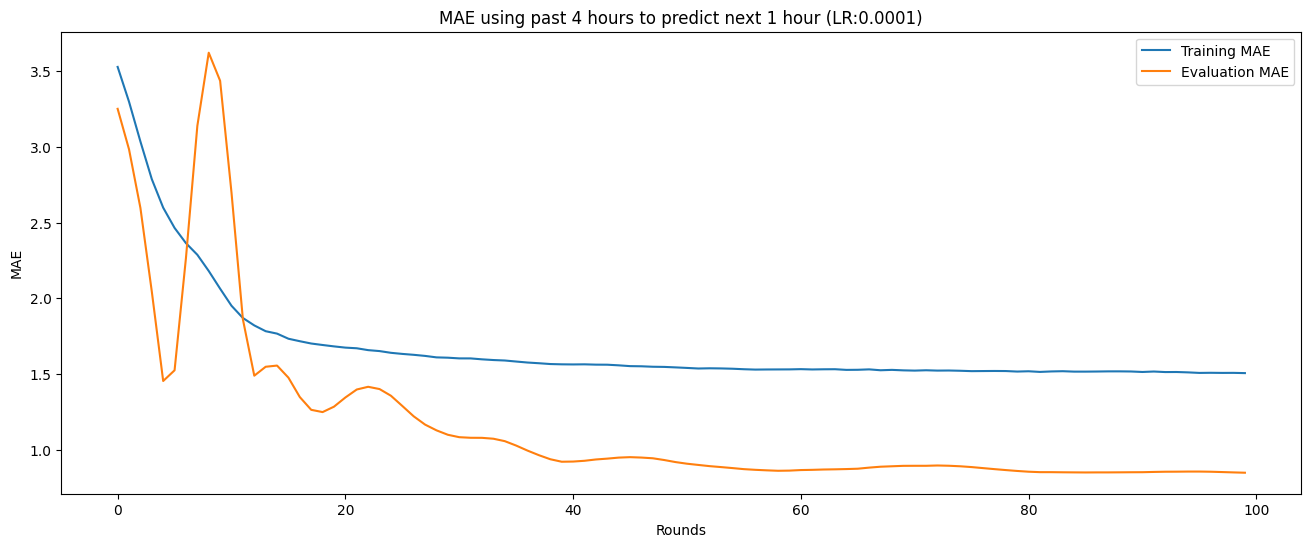

In [52]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [53]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_4h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 29ms/step


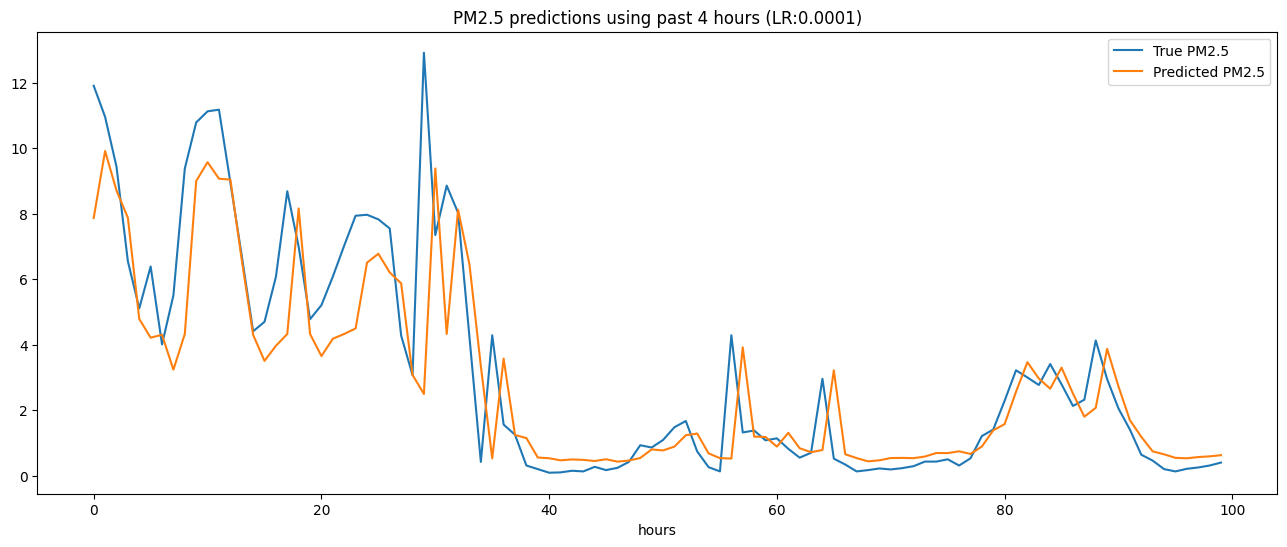

In [54]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [55]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.862371,0.847486


# Past 6

In [56]:
past = 6
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [57]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-19-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.0072 MAE:3.3730, Loss:3.3730 | Eval - RMSE:4.6766 MAE:3.1816, Loss:3.1816 | Time - 45.96
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:6.7899 MAE:3.2327, Loss:3.2327 | Eval - RMSE:4.3663 MAE:2.8798, Loss:2.8798 | Time - 43.75
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.4496 MAE:3.0466, Loss:3.0466 | Eval - RMSE:3.8667 MAE:2.4628, Loss:2.4628 | Time - 45.33
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.0524 MAE:2.8577, Loss:2.8577 | Eval - RMSE:3.2017 MAE:1.9325, Loss:1.9325 | Time - 45.28
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:5.7197 MAE:2.7034, Loss:2.7034 | Eval - RMSE:2.6102 MAE:1.4662, Loss:1.4662 | Time - 43.53
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.4086 MAE:2.5716, Loss:2.5716

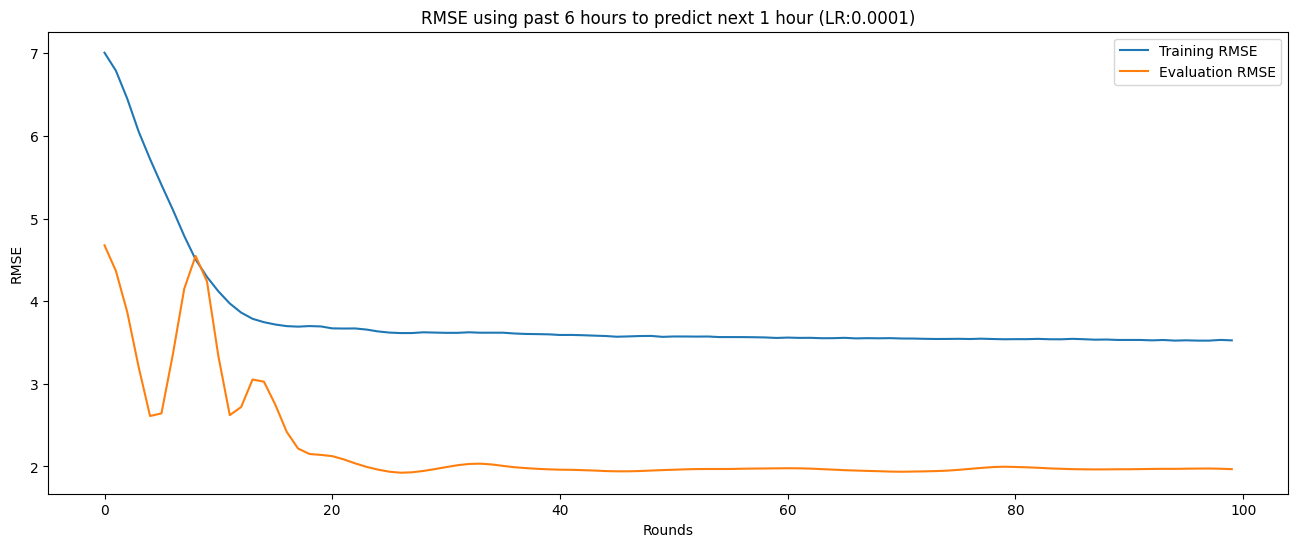

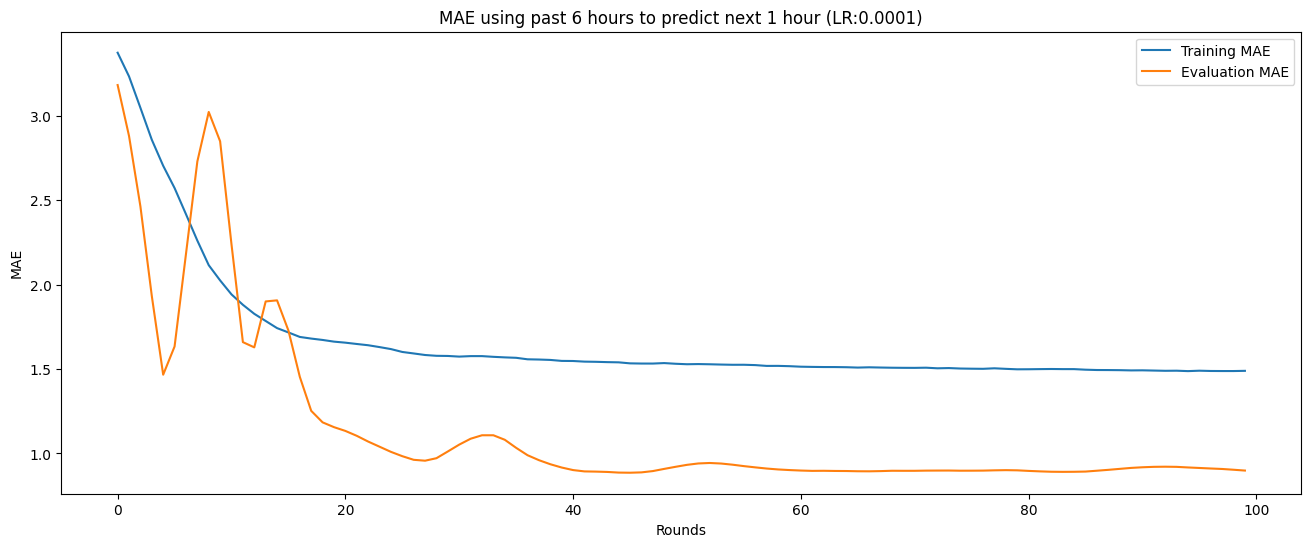

In [58]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [59]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_6h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 28ms/step


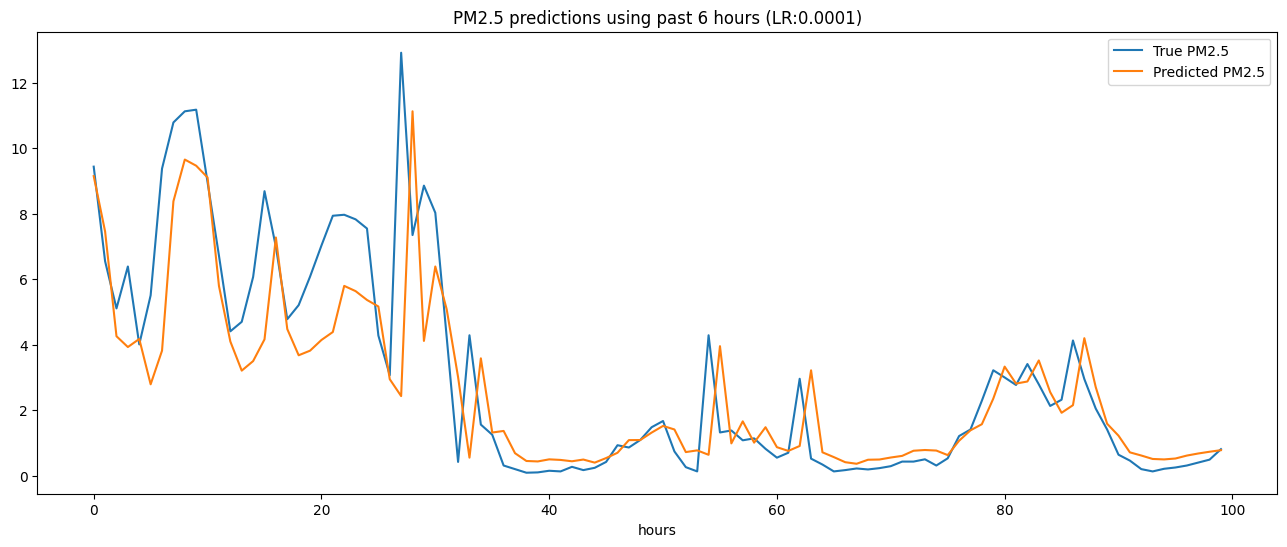

In [60]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [61]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.923881,0.885666


# Past 8

In [62]:
past = 8
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [63]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-19-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.1919 MAE:3.4933, Loss:3.4933 | Eval - RMSE:4.6848 MAE:3.1582, Loss:3.1582 | Time - 58.15
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.0351 MAE:3.3847, Loss:3.3847 | Eval - RMSE:4.4173 MAE:2.8957, Loss:2.8957 | Time - 49.72
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.7468 MAE:3.2184, Loss:3.2184 | Eval - RMSE:4.0463 MAE:2.5743, Loss:2.5743 | Time - 48.32
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.3985 MAE:3.0560, Loss:3.0560 | Eval - RMSE:3.5454 MAE:2.1509, Loss:2.1509 | Time - 48.14
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.0715 MAE:2.8937, Loss:2.8937 | Eval - RMSE:2.9936 MAE:1.7266, Loss:1.7266 | Time - 56.26
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.7380 MAE:2.7235, Loss:2.7235

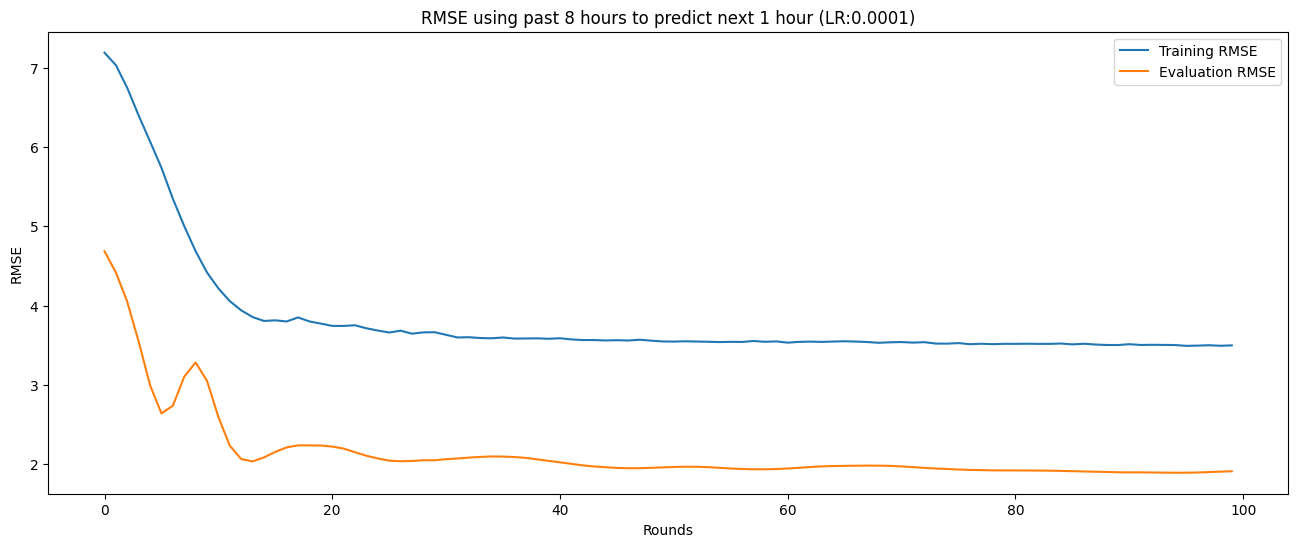

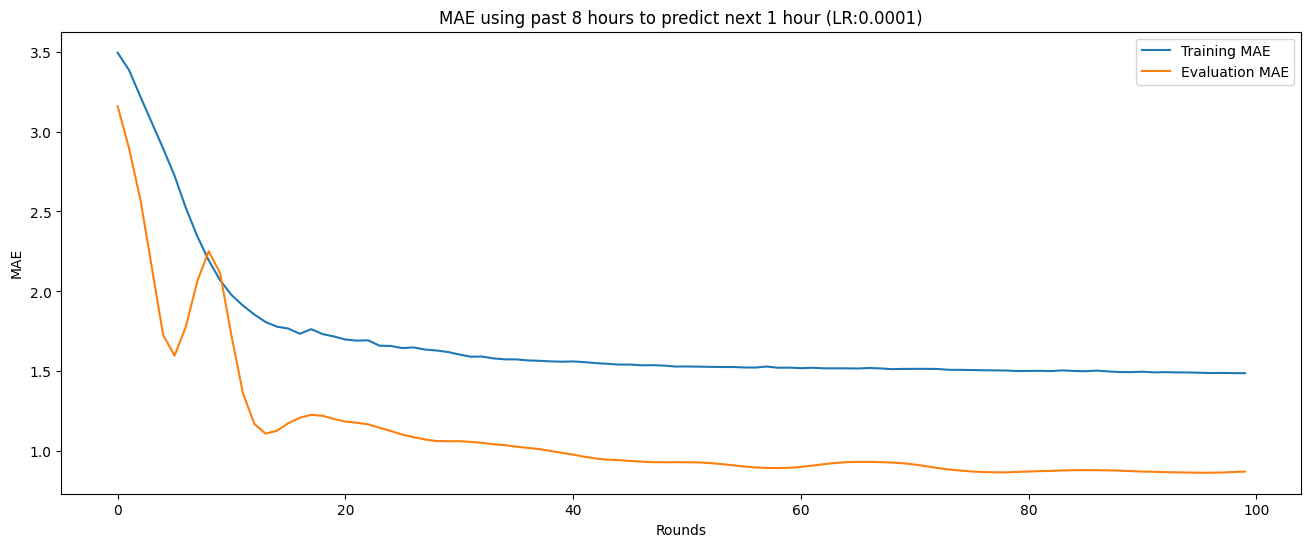

In [64]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [65]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_8h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 23ms/step


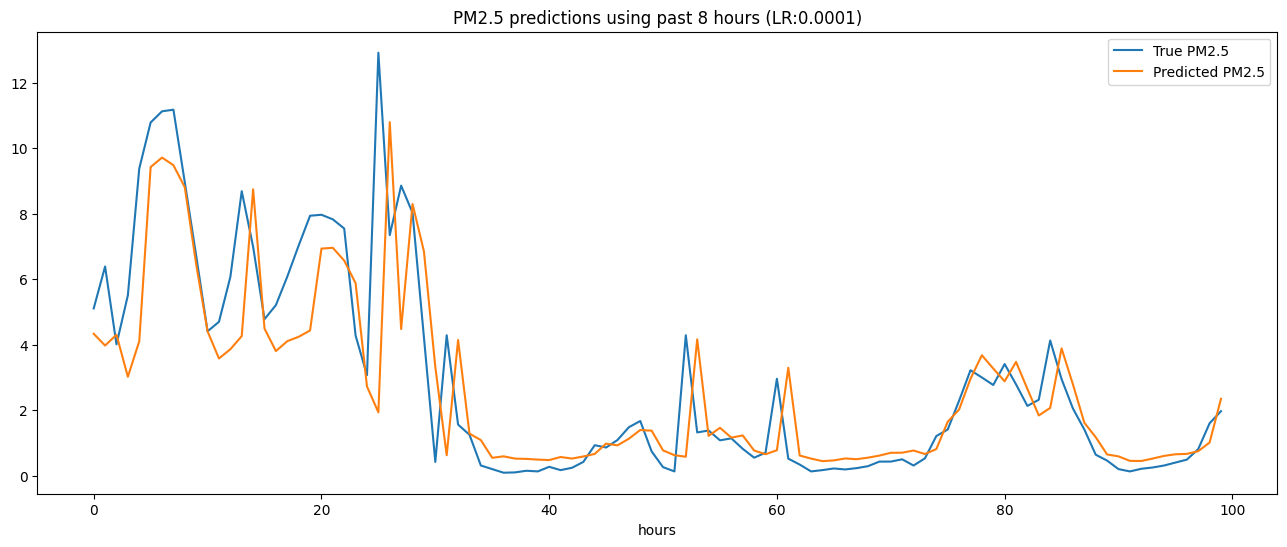

In [66]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [67]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.888915,0.865791


# Past 10

In [68]:
past = 10
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [69]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-19-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:7.3889 MAE:3.6511, Loss:3.6511 | Eval - RMSE:4.6282 MAE:3.1004, Loss:3.1004 | Time - 63.87
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:7.2608 MAE:3.5345, Loss:3.5345 | Eval - RMSE:4.4025 MAE:2.8807, Loss:2.8807 | Time - 52.60
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:7.0018 MAE:3.3718, Loss:3.3718 | Eval - RMSE:4.0390 MAE:2.5719, Loss:2.5719 | Time - 57.13
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.6494 MAE:3.1904, Loss:3.1904 | Eval - RMSE:3.5405 MAE:2.1666, Loss:2.1666 | Time - 55.07
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:6.2910 MAE:3.0022, Loss:3.0022 | Eval - RMSE:2.9886 MAE:1.7288, Loss:1.7288 | Time - 57.48
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.9074 MAE:2.7809, Loss:2.7809

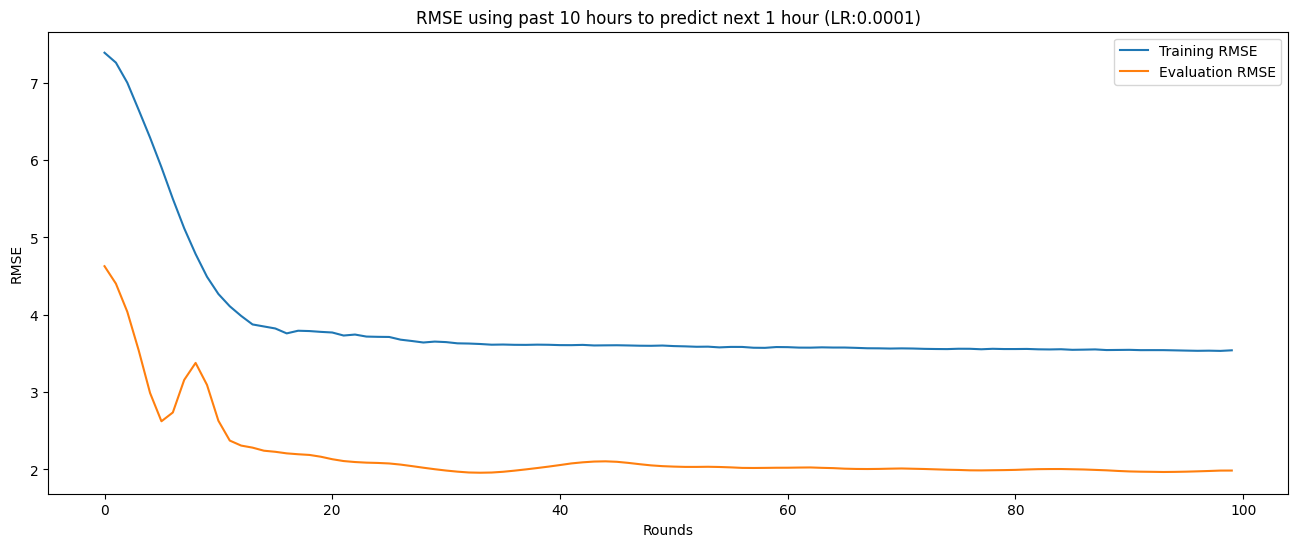

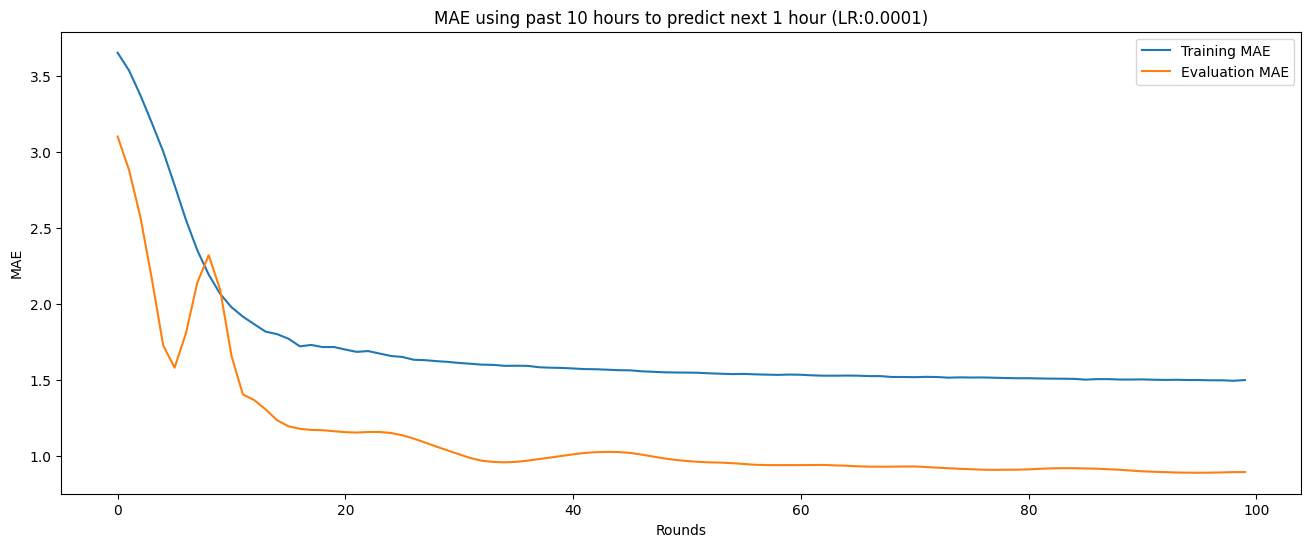

In [70]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [ ]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_10h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

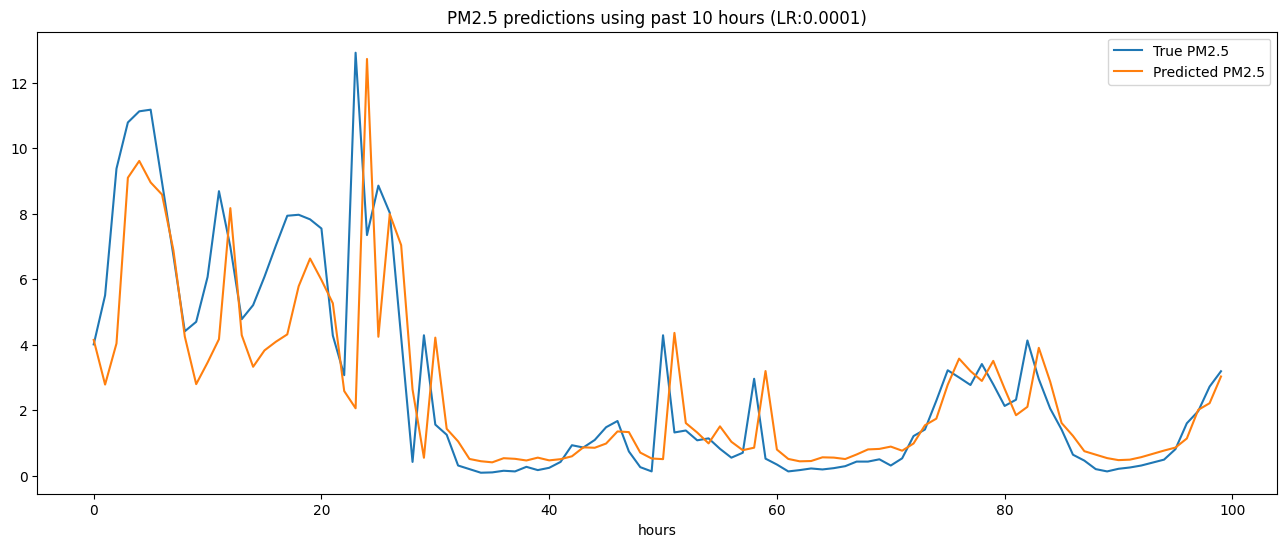

In [79]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [77]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.957177,0.892333


# Past 12

In [14]:
past = 12
x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=0.80)
s1_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(1)

x_train, y_train, x_val, y_val = make_dataset(s1, past, split_fraction=1.0)
s2_train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(1)

train_data = [s1_train_data, s2_train_data]

In [15]:
SERVER_LR = 0.0001
CLIENT_LR = 0.1

server_optimizer_fn, client_optimizer_fn = optimizers(SERVER_LR, CLIENT_LR)

trainer = tff.learning.algorithms.build_weighted_fed_avg(
        model_fn,
        server_optimizer_fn,
        client_optimizer_fn,
    )

state2, train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2 = train(
    trainer,
    train_data,
    val_data,
    num_rounds=ROUNDS,
    no_of_clients=NUM_CLIENTS,
    fit_on=NUM_FIT
)

<ipython-input-5-caa6a9de1554>:13: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval = tff.learning.build_federated_evaluation(model_fn)


Training...
Evaluating...
Done...
Round:1 Train - RMSE:6.9560 MAE:3.4120, Loss:3.4120 | Eval - RMSE:4.6978 MAE:3.1964, Loss:3.1964 | Time - 78.49
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:2 Train - RMSE:6.8193 MAE:3.3183, Loss:3.3183 | Eval - RMSE:4.4860 MAE:2.9790, Loss:2.9790 | Time - 83.79
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:3 Train - RMSE:6.5546 MAE:3.1474, Loss:3.1474 | Eval - RMSE:4.1367 MAE:2.6719, Loss:2.6719 | Time - 75.20
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:4 Train - RMSE:6.1326 MAE:2.8928, Loss:2.8928 | Eval - RMSE:3.5610 MAE:2.2063, Loss:2.2063 | Time - 69.48
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:5 Train - RMSE:5.6874 MAE:2.6463, Loss:2.6463 | Eval - RMSE:2.7621 MAE:1.5664, Loss:1.5664 | Time - 72.43
Loss improved!
Saving model state...
Training...
Evaluating...
Done...
Round:6 Train - RMSE:5.3331 MAE:2.4509, Loss:2.4509

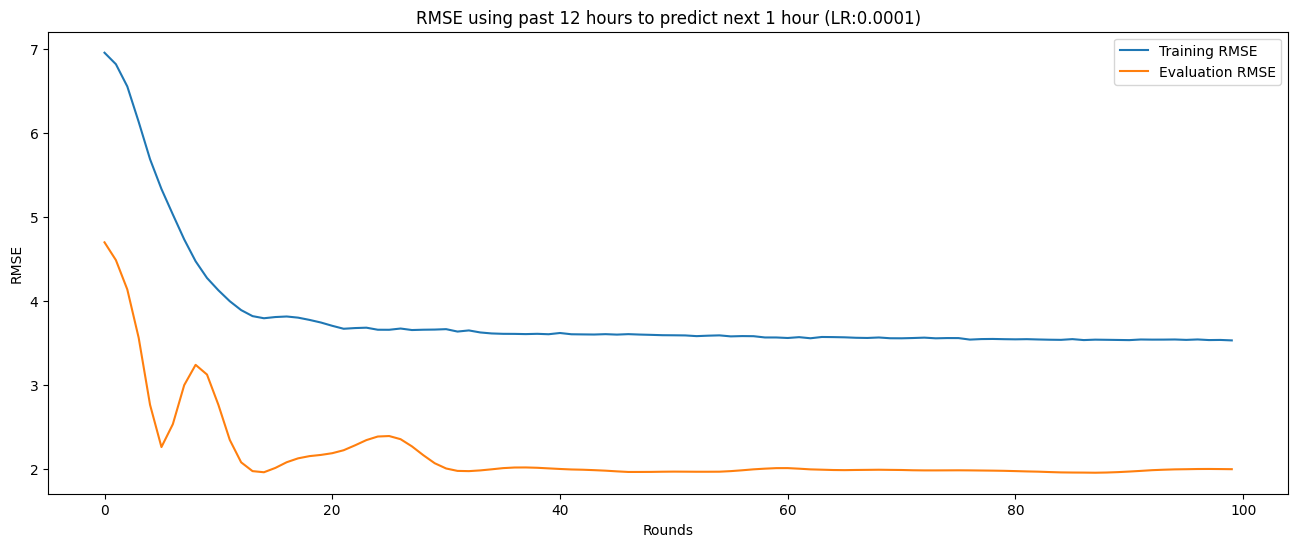

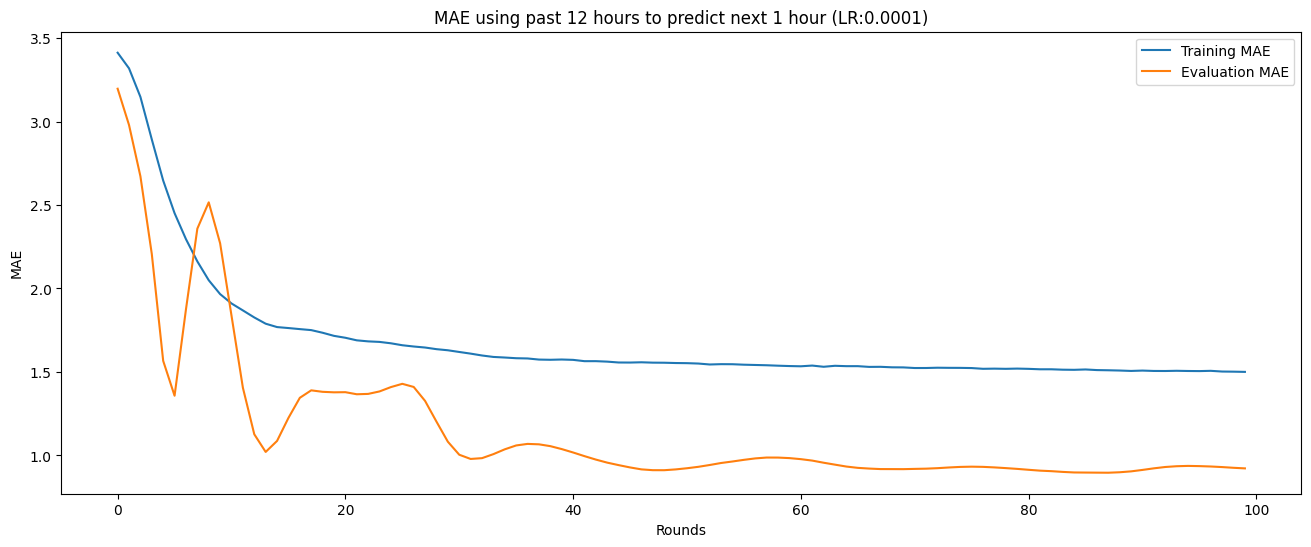

In [16]:
plot(train_acc2, train_mse2, train_loss2, eval_acc2, eval_mse2, eval_loss2)

In [17]:
test_log_dir = "logs/past_" + str(past) + "_hours_" + str(SERVER_LR) + "_test"
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

model_test2 = create_model_fn()
trained_model = trainer.get_model_weights(state2)
trained_model.assign_weights_to(model_test2)
model_test2.save_weights('./checkpoints/private_data/past_12h')
# # plot_preds(model_test2, val_set)

predictions = []
true_val = []
index = 0
for x, y in val_data.skip(100).take(100):
  [pred] = model_test2.predict(x)[0]
  [true] = y[0].numpy()
  with test_summary_writer.as_default():
    tf.summary.scalar("predictions/true" ,true, step=index+1)
    tf.summary.scalar("predictions/predicted" ,pred, step=index+1)
  index += 1

  predictions.append(pred)
  true_val.append(true)

1/1 [==============================] - 0s 32ms/step


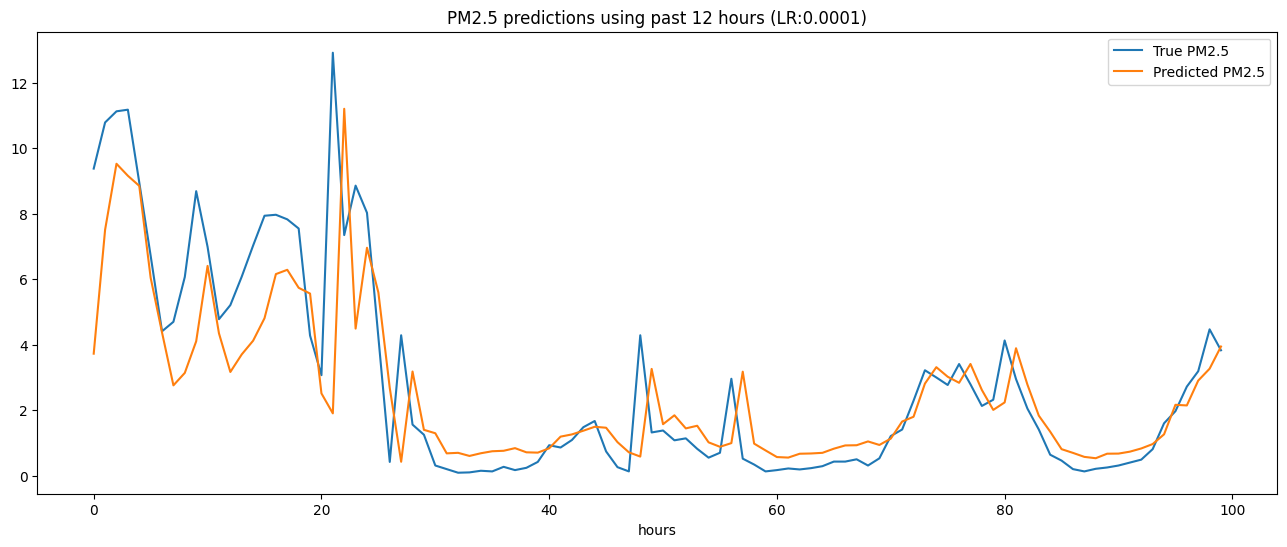

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(true_val, label="True PM2.5")
plt.plot(predictions, label="Predicted PM2.5")
plt.title("PM2.5 predictions using past " + str(past) +" hours (LR:" + str(SERVER_LR)+ ")")
plt.xlabel("hours")
plt.legend()
plt.show()

In [19]:
pd.DataFrame({
    "Train Clients": [NUM_FIT],
    "Epochs": [ROUNDS],
    "Server LR": ["0.0001"],
    "Client LR": [0.1],
    "Validation RMSE": [min(eval_acc2)],
    "Validation MAE": [min(eval_mse2)]
})

,Train Clients,Epochs,Server LR,Client LR,Validation RMSE,Validation MAE
0,5,100,0.0001,0.1,1.953743,0.896357
